# prev

In [2]:
# =============================================================
# GPU-accelerated Optimal-Transport MDS on raw PBMC3k
# =============================================================
import scanpy as sc
import cupy as cp                        # GPU 배열
import numpy as np
import matplotlib.pyplot as plt
# import pot                                # POT >=0.9  (GPU 지원)
from cupyx.scipy.spatial import distance # SciPy API on GPU

In [3]:
# ----------------------------------------------------
# 1) 원본 raw PBMC3k 불러오기 & 전처리
# ----------------------------------------------------
adata = sc.datasets.pbmc3k()             # 2,638 cells × 3,346 genes
adata.var_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# → 희소 CSR (cells × genes).  GPU 연산 위해 dense 로 변환
X = adata.X.toarray().astype(np.float32)        # (cells, genes)
print("shape:", X.shape)

shape: (2700, 2000)


In [4]:
# ----------------------------------------------------
# 2) 각 셀을 확률 분포로 (row sum = 1)
# ----------------------------------------------------
row_sums = X.sum(axis=1, keepdims=True)
P_cpu = X / row_sums
P      = cp.asarray(P_cpu)               # → GPU

In [5]:
# 3) OT(=½·L1) 거리 행렬 (GPU cdist 사용)
#    ─ ground cost: C_ij = 1 for i≠j → OT = ½·L1
# ----------------------------------------------------
# cupyx에서 cdist으로 바로 (n×n) 행렬 계산
D_l1 = distance.cdist(P, P, metric='cityblock')  # GPU 상에서 (n,n) L1 distances
D_ot = 0.5 * D_l1

del D_l1       

In [6]:
# ----------------------------------------------------
# 4) Classical MDS (B = -½ J D² J)  GPU eigs
# ----------------------------------------------------
n = D_ot.shape[0]
J = cp.eye(n) - cp.ones((n,n))/n
B = -0.5 * J @ (D_ot**2) @ J

# 상위 2개 고윳값·벡터
eigs, vecs = cp.linalg.eigh(B)
idx        = cp.argsort(eigs)[::-1]       # 내림차순
eigs,vecs  = eigs[idx][:2], vecs[:,idx][:,:2]

coords = vecs * cp.sqrt(cp.clip(eigs,0,None))   # (cells, 2)
coords = cp.asnumpy(coords)        

/tmp/ipykernel_105265/1939380520.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added='leiden')


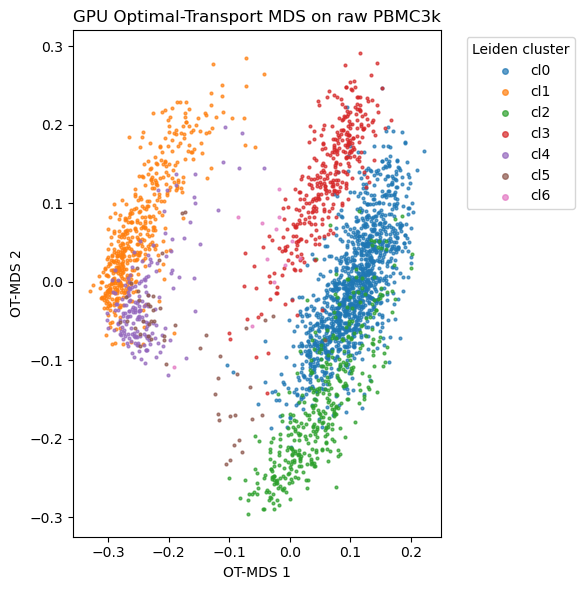

In [7]:
# ----------------------------------------------------
# 5) 시각화
# ----------------------------------------------------
# PBMC3k(raw)에는 cell type annotation이 없음 → 클러스터별 색
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')  # X = HVG space
sc.tl.leiden(adata, resolution=1.0, key_added='leiden')

labels = adata.obs['leiden'].values

plt.figure(figsize=(6,6))
for lab in np.unique(labels):
    sel = labels == lab
    plt.scatter(coords[sel,0], coords[sel,1],
                s=4, alpha=0.7, label=f'cl{lab}')
plt.xlabel('OT-MDS 1')
plt.ylabel('OT-MDS 2')
plt.title('GPU Optimal-Transport MDS on raw PBMC3k')
plt.legend(title='Leiden cluster',
           markerscale=2, bbox_to_anchor=(1.05,1),
           loc='upper left')
plt.tight_layout()
plt.show()

## New algorithm

In [8]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial import distance

In [9]:
# 1) Load & preprocess raw PBMC3k
adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
X = adata.X.toarray().astype(np.float32)


In [10]:
# 2) Global OT distance matrix (½·L1)
P = X / X.sum(axis=1, keepdims=True)
D_ot = distance.squareform(distance.pdist(P, metric='cityblock')) * 0.5

In [11]:
# 3) Local graph distance (symmetrized)
sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
D_local = adata.obsp['distances'].toarray()
D_local = (D_local + D_local.T) / 2

In [12]:
# 4) Composite & enforce symmetry
lambda_ = 0.1
D_comp = D_ot + lambda_ * D_local
D_comp = (D_comp + D_comp.T) / 2

In [13]:
# 5) MDS
mds = MDS(
    n_components=2,
    dissimilarity='precomputed',
    random_state=0,
    n_init=4,
    max_iter=300
)
coords = mds.fit_transform(D_comp)

KeyboardInterrupt: 

In [ ]:
# 6) Leiden for coloring
sc.tl.leiden(adata, resolution=1.0, key_added='leiden')
labels = adata.obs['leiden'].values

In [ ]:
# 7) Plot
plt.figure(figsize=(6,6))
for lab in np.unique(labels):
    mask = labels == lab
    plt.scatter(coords[mask,0], coords[mask,1], s=4, alpha=0.7, label=f'cl{lab}')
plt.xlabel('AGW-Embed 1')
plt.ylabel('AGW-Embed 2')
plt.title('AGW-Embed (OT+Graph) on raw PBMC3k')
plt.legend(title='Leiden Cluster', markerscale=2,
           bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

ValueError: Array must be symmetric

# GPU ver

In [1]:
# GPU-accelerated AGW-Embed on raw PBMC3k
import scanpy as sc
import cupy as cp
from cupyx.scipy.spatial import distance  # GPU cdist
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 1) Load & preprocess raw PBMC3k


adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
X = adata.X.toarray().astype(np.float32)  # (n_cells, n_genes)

# 2) Global OT distance (½·L1) on GPU
P = cp.asarray(X)
P = P / cp.sum(P, axis=1, keepdims=True)  # row-sum = 1
D_l1 = distance.cdist(P, P, metric='cityblock')  # (n,n) L1 distances
D_ot = 0.5 * D_l1
del D_l1  # free memory

# 3) Local graph distances (CPU → GPU)
sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
D_local = adata.obsp['distances'].toarray().astype(np.float32)
D_local = (D_local + D_local.T) / 2              # symmetrize
D_local_gpu = cp.asarray(D_local)

# 4) Composite distance & GPU MDS
lambda_ = 0.1
D_comp = D_ot + lambda_ * D_local_gpu
D_comp = (D_comp + D_comp.T) / 2                 # enforce symmetry

n = D_comp.shape[0]
J = cp.eye(n, dtype=cp.float32) - cp.ones((n,n), dtype=cp.float32)/n
B = -0.5 * J.dot(D_comp**2).dot(J)

# eigen-decompose B on GPU
eigs, vecs = cp.linalg.eigh(B)
idx = cp.argsort(eigs)[::-1][:2]
L = cp.sqrt(cp.clip(eigs[idx], 0, None))
coords_gpu = vecs[:, idx] * L

# move to CPU for plotting
coords = cp.asnumpy(coords_gpu)

/root/miniconda3/envs/my_algo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_105102/947400826.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added='leiden')


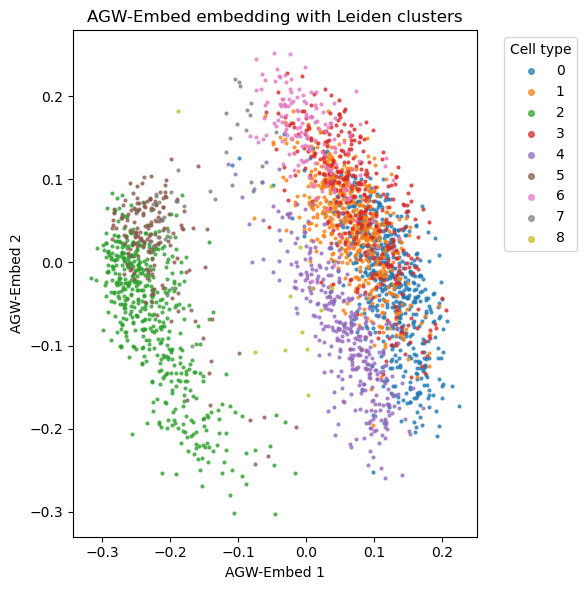

In [8]:
# 5) Leiden clustering for coloring
sc.tl.leiden(adata, resolution=1.0, key_added='leiden')
labels = adata.obs['leiden'].values

# 6) Plot
plt.figure(figsize=(6,6))
for lab in np.unique(labels):
    sel = labels == lab
    plt.scatter(coords[sel,0], coords[sel,1],
                s=4, alpha=0.7, label=f'{lab}')
plt.xlabel('AGW-Embed 1')
plt.ylabel('AGW-Embed 2')
plt.title('AGW-Embed embedding with Leiden clusters')
plt.legend(title='Cell type',
           markerscale=2,
           bbox_to_anchor=(1.05,1),
           loc='upper left')
plt.tight_layout()
plt.show()

/root/miniconda3/envs/my_algo/lib/python3.9/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/root/miniconda3/envs/my_algo/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


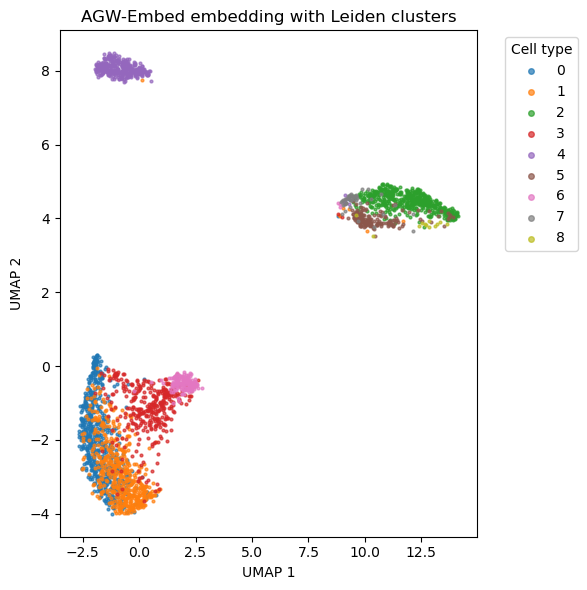

In [9]:
import umap

# --- 이전 단계까지 그대로 ---
# 1) Load & preprocess raw PBMC3k
adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
X = adata.X.toarray().astype(np.float32)  # (n_cells, n_genes)

# 2) Global OT distance (GPU)
P = cp.asarray(X)
P = P / cp.sum(P, axis=1, keepdims=True)
D_l1 = distance.cdist(P, P, metric='cityblock')
D_ot = 0.5 * D_l1
del D_l1

# 3) Local graph distances (CPU → GPU)
sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
D_local = adata.obsp['distances'].toarray().astype(np.float32)
D_local = (D_local + D_local.T) / 2
D_local_gpu = cp.asarray(D_local)

# 4) Composite distance (no MDS)
lambda_ = 0.1
D_comp = D_ot + lambda_ * D_local_gpu
D_comp = (D_comp + D_comp.T) / 2

# 5) Leiden clustering (for coloring)
sc.tl.leiden(adata, resolution=1.0, key_added='leiden')
labels = adata.obs['leiden'].values

# 6) UMAP embedding on composite distance
#    - metric='precomputed' 으로 D_comp (거리행렬) 사용
D_comp_cpu = cp.asnumpy(D_comp)              # GPU → CPU
reducer = umap.UMAP(
    n_components=2,
    metric='precomputed',
    random_state=42
)
coords_umap = reducer.fit_transform(D_comp_cpu)  # (n_cells, 2)

# 7) Plot
plt.figure(figsize=(6,6))
for lab in np.unique(labels):
    sel = labels == lab
    plt.scatter(coords_umap[sel,0], coords_umap[sel,1],
                s=4, alpha=0.7, label=f'{lab}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('AGW-Embed embedding with Leiden clusters')
plt.legend(title='Cell type', markerscale=2,
           bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

### Evaluation metric

In [3]:
import cupy as cp
from sklearn.neighbors import NearestNeighbors

def evaluate_embedding_gpu(
    X_hi_cp, Z_low_cp,
    k=30,
    n_pairs=100_000,
    random_state=0
):
    """
    - GPU 상에서 거리 샘플링, Pearson corr, 1D EMD 계산
    - KNN overlap 은 sklearn NearestNeighbors 로 CPU 상에서 계산
    """
    N = X_hi_cp.shape[0]
    rs = cp.random.RandomState(random_state)
    idx = rs.randint(0, N, size=(n_pairs, 2))

    # 1) 샘플링된 거리 계산 (GPU)
    Dx = cp.linalg.norm(
        X_hi_cp[idx[:, 0]] - X_hi_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)
    Dz = cp.linalg.norm(
        Z_low_cp[idx[:, 0]] - Z_low_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)

    # 2) GPU 위에서 Pearson correlation 계산
    x_mean = Dx.mean()
    z_mean = Dz.mean()
    cov    = ((Dx - x_mean) * (Dz - z_mean)).mean()
    std_x  = (Dx - x_mean).std()
    std_z  = (Dz - z_mean).std()
    corr   = cov / (std_x * std_z + 1e-8)

    # 3) 1D EMD via 정렬 (GPU)
    Dx_s = cp.sort(Dx)
    Dz_s = cp.sort(Dz)
    emd  = cp.mean(cp.abs(Dx_s - Dz_s))

    # 4) KNN-overlap (CPU, sklearn)
    X_np = cp.asnumpy(X_hi_cp)
    Z_np = cp.asnumpy(Z_low_cp)

    nn_hi = NearestNeighbors(n_neighbors=k+1).fit(X_np)
    nn_lo = NearestNeighbors(n_neighbors=k+1).fit(Z_np)

    knn_hi = nn_hi.kneighbors(X_np, return_distance=False)[:, 1:]
    knn_lo = nn_lo.kneighbors(Z_np, return_distance=False)[:, 1:]

    overlap = (knn_hi[:, :, None] == knn_lo[:, None, :]).any(-1).mean()

    return {
        'corr':     float(corr),
        'emd':      float(emd),
        'knn_pres': float(overlap)
    }

In [4]:
# GPU 상의 원본 고차원, embedding
X_hi_cp  = cp.asarray(X)           # X: (n_cells, n_genes) numpy array
Z_low_cp = coords_gpu              # coords_gpu: (n_cells, 2) cupy array

scores = evaluate_embedding_gpu(
    X_hi_cp, Z_low_cp,
    k=30,
    n_pairs=100_000,
    random_state=0
)

print("Pearson corr     :", scores['corr'])
print("1D EMD            :", scores['emd'])
print("KNN overlap rate :", scores['knn_pres'])

Pearson corr     : 0.5989425182342529
1D EMD            : 27.485885620117188
KNN overlap rate : 0.049506172839506174


In [6]:
# 실루엣 스코어 계산
from sklearn.metrics import silhouette_score

# 라벨을 숫자로 변환 (실루엣 스코어 계산을 위해)
labels_numeric = np.zeros(len(labels), dtype=int)
for i, lab in enumerate(np.unique(labels)):
    labels_numeric[labels == lab] = i

# 임베딩에 대한 실루엣 스코어 계산
sil_score = silhouette_score(coords, labels_numeric)
print(f"Silhouette Score: {sil_score:.4f}")

# 원본 고차원 데이터에 대한 실루엣 스코어 계산 (비교용)
# PCA 공간에서 계산 (계산 효율성을 위해)
sil_score_orig = silhouette_score(adata.obsm['X_pca'], labels_numeric)
print(f"Original Data Silhouette Score (PCA space): {sil_score_orig:.4f}")

# 실루엣 스코어를 기존 평가 지표와 함께 출력
print("\n=== 임베딩 평가 지표 ===")
print(f"Pearson correlation: {scores['corr']:.4f}")
print(f"1D EMD: {scores['emd']:.4f}")
print(f"KNN overlap rate: {scores['knn_pres']:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0097
Original Data Silhouette Score (PCA space): 0.1106

=== 임베딩 평가 지표 ===
Pearson correlation: 0.5989
1D EMD: 27.4859
KNN overlap rate: 0.0495
Silhouette Score: 0.0097


In [3]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph, csr_matrix
from scipy.sparse.linalg import eigsh

def compute_spectrum(coords, k=15, r=20):
    """
    Build a symmetric, Gaussian‐weighted k-NN graph on coords,
    compute the normalized Laplacian’s smallest r+1 eigenvalues.
    """
    # 1) distance‐based k-NN graph
    D = kneighbors_graph(coords, n_neighbors=k, mode='distance',
                         include_self=False)
    D = 0.5 * (D + D.T)

    # 2) Gaussian kernel weights
    sigma = np.median(D.data)
    W_data = np.exp(- (D.data**2) / (2 * sigma**2 + 1e-16))
    W = csr_matrix((W_data, D.indices, D.indptr), shape=D.shape)
    W = 0.5 * (W + W.T)

    # 3) normalized Laplacian
    L = csgraph.laplacian(W, normed=True)

    # 4) compute smallest r+1 eigenvalues
    m = min(r+1, L.shape[0]-2)
    vals, _ = eigsh(L, k=m, which='SM', tol=1e-3)
    vals = np.sort(vals)
    if vals.shape[0] < r+1:
        vals = np.concatenate([vals, np.zeros(r+1 - vals.shape[0])])
    return vals

def spectral_graph_concordance(vals_nat, vals_lat, r=20):
    """
    SGC(r) = 1 - sum_i |λ_nat_i - λ_lat_i| / sum_i λ_nat_i, clipped to [0,1].
    """
    diff = np.abs(vals_nat[1:r+1] - vals_lat[1:r+1]).sum()
    denom = vals_nat[1:r+1].sum()
    if denom <= 0:
        return 0.0
    return float(np.clip(1 - diff/denom, 0.0, 1.0))

# ----------------------------------------
# 1) Compute native‐space spectrum once
# ----------------------------------------
k, r = 15, 20
native_coords = adata.obsm['X_pca'][:, :50]  # use first 50 PCs in native space
vals_nat = compute_spectrum(native_coords, k=k, r=r)

# ----------------------------------------
# 2) Compute SGC for the AGW‐Embed coords
# ----------------------------------------
# 'coords' is the (n_cells, 2) array from your GPU AGW‐Embed MDS
vals_lat = compute_spectrum(coords, k=k, r=r)
sgc_value = spectral_graph_concordance(vals_nat, vals_lat, r=r)

print(f"AGW-Embed Spectral Graph Concordance (r={r}, k={k}): {sgc_value:.3f}")


AGW-Embed Spectral Graph Concordance (r=20, k=15): 0.075
